In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="ARDRBTC", time="2019-04-17 17:00:04", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(minutes=5))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]

df.head()

,price,qty,time,isBuyerMaker,quote
0,0.000017,595.0,2019-03-18 17:00:08.126,False,0.009984
1,0.000017,118.0,2019-03-18 17:02:30.720,True,0.001978
2,0.000017,851.0,2019-03-18 17:02:30.822,False,0.014263
3,0.000017,237.0,2019-03-18 17:02:49.816,True,0.003965
4,0.000017,6221.0,2019-03-18 17:02:49.816,True,0.104077


<h4>Features 25.04.2024</h4>

In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
0,2019-03-18 17:00:08.126,0.000017,0.000017,0.000017,0.000017,595.0,595.0,0.009984,0.009984,True
1,2019-03-18 17:02:30.720,0.000017,0.000017,0.000017,0.000017,-118.0,118.0,-0.001978,0.001978,False


<h4>BTC slippage</h4>

$$\text{BTC\_lost\_to\_slippage} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\text{Quote could have been spent if filled at best price}}$$

In [23]:
df_trades["quote_slippage_abs"] = (
    df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])

<h4>Features</h4>

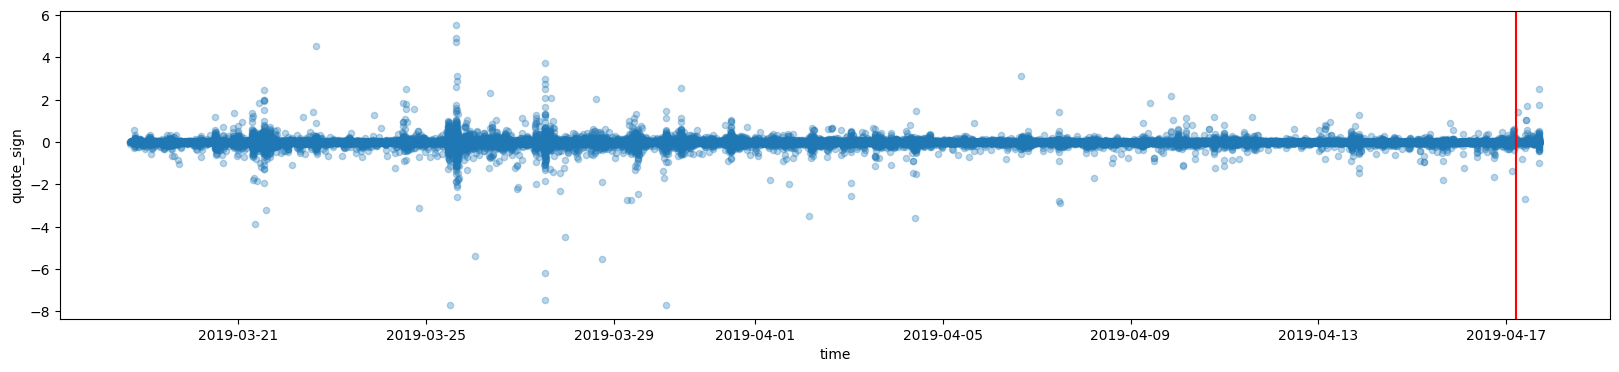

In [7]:
df_trades.plot.scatter(
    x="time", y="quote_sign", figsize=(20, 4), alpha=.3
)
plt.axvline(x=pump.time.floor("1h") - timedelta(hours=12), color="red")
plt.show()

<h4>Trades timings</h4>

In [8]:
total_day_seconds = 24*60*60

df_trades["day_seconds_elapsed"] = pd.to_timedelta(
    df_trades["time"].dt.time.astype(str)
).dt.total_seconds()

df_trades["sin_time"] = np.sin(2*np.pi*df_trades.day_seconds_elapsed / total_day_seconds)
df_trades["cos_time"] = np.cos(2*np.pi*df_trades.day_seconds_elapsed / total_day_seconds)
df_trades["time_diff"] = df_trades["time"].diff().dt.total_seconds()

df_trades = df_trades.dropna()

In [9]:
df_trades_7d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1d") - timedelta(days=7)
].copy()

<h4>Sin, Cos transformation of time</h4>

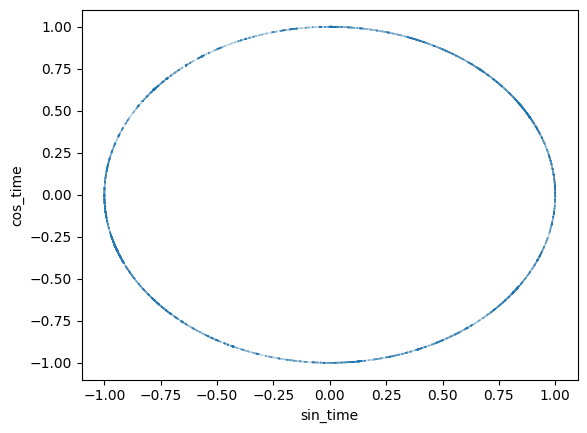

In [10]:
df_trades_7d.plot.scatter(
    x="sin_time", y="cos_time", 
    s=df_trades_7d["quote_abs"] / df_trades_7d["quote_abs"].max(), 
    alpha=.5
)
plt.show()

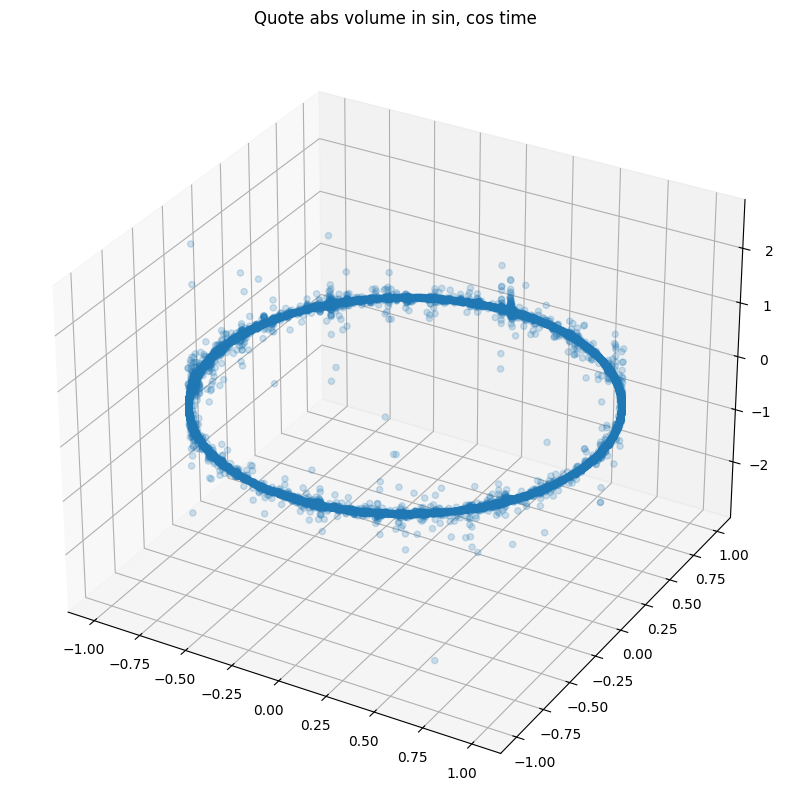

In [11]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")
ax.scatter(
    df_trades_7d["sin_time"], df_trades_7d["cos_time"], df_trades_7d["quote_sign"], alpha=.2
)

plt.title("Quote abs volume in sin, cos time")
plt.show()

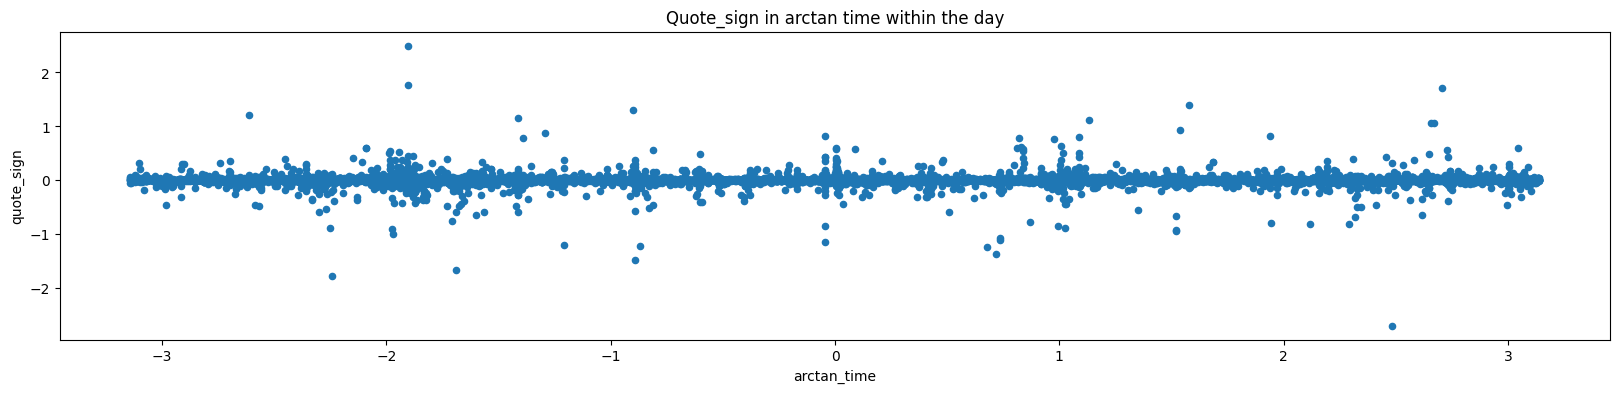

In [12]:
df_trades_7d["arctan_time"] = np.arctan2(df_trades_7d["sin_time"], df_trades_7d["cos_time"])

df_trades_7d.plot.scatter(x="arctan_time", y="quote_sign", figsize=(20, 4))
plt.title("Quote_sign in arctan time within the day")
plt.show()

In [13]:
from sklearn.metrics import auc

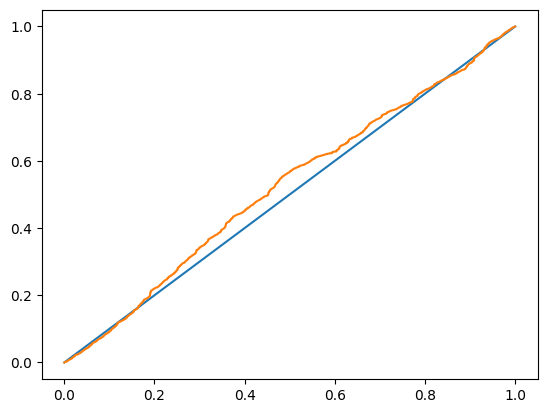

In [14]:
df_circle: pd.DataFrame = df_trades_7d.copy()
N = df_circle.shape[0]

df_circle = df_circle.sort_values(by="arctan_time", ascending=True).reset_index(drop=True)
df_circle["cumsum_ratio"] = df_circle["quote_abs"].cumsum() / df_circle["quote_abs"].sum()

X = np.linspace(0, 1, N)
Y = X

plt.plot(X, Y)
plt.plot(X, df_circle["cumsum_ratio"])

plt.show()

In [15]:
deviation_auc = auc(x=X, y=np.abs(df_circle["cumsum_ratio"] - Y))
deviation_auc

0.025229083739106074

<h4>Short timeframe features</h4>

In [16]:
from sklearn.metrics import auc

<h4>1D Trading volume AUC binned 1H</h4>

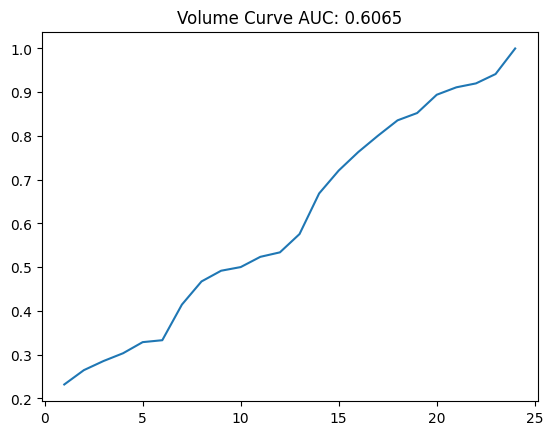

In [17]:
df_trades_2d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1h") - timedelta(days=2)
].copy()

df_vol: pd.DataFrame = df_trades_2d.resample(on="time", rule="1h")["quote_abs"].sum().to_frame()
# Reverse order as it is expected that the volume is high closer to the pump
df_vol: pd.DataFrame = df_vol.iloc[-24:]
df_vol = df_vol.iloc[::-1]

df_vol["cumsum_ratio"] = df_vol.cumsum() / df_vol.sum()
auc_score: float = auc(x=np.linspace(0, 1, 24), y=df_vol["cumsum_ratio"])

plt.plot(range(1, 25), df_vol["cumsum_ratio"])
plt.title(f"Volume Curve AUC: {round(auc_score, 4)}")
plt.show()

<h4>12h Trading volume AUC binned 15min</h4>

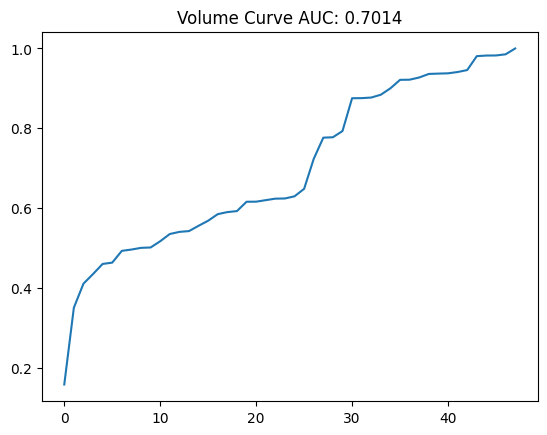

In [18]:
df_trades_1d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1h") - timedelta(days=1)
].copy()

df_vol: pd.DataFrame = df_trades_1d.resample(on="time", rule="15min")["quote_abs"].sum().to_frame()
df_vol: pd.DataFrame = df_vol.iloc[-12*4:]
# Reverse order as it is expected that the volume is high closer to the pump
df_vol = df_vol.iloc[::-1]

df_vol["cumsum_ratio"] = df_vol.cumsum() / df_vol.sum()

auc_score: float = auc(x=np.linspace(0, 1, 48), y=df_vol["cumsum_ratio"])

plt.plot(range(48), df_vol["cumsum_ratio"])
plt.title(f"Volume Curve AUC: {round(auc_score, 4)}")
plt.show()

<h4>Quote Slippage (relative to overall slippages) 12hr curve AUC</h4>

<p>Hypothesis: pre-pump we can observe higher slippages in BTC as insider rush in to fill in their positions. Therefore, we need features describing the skew of the slippages closer to the pump time</p>

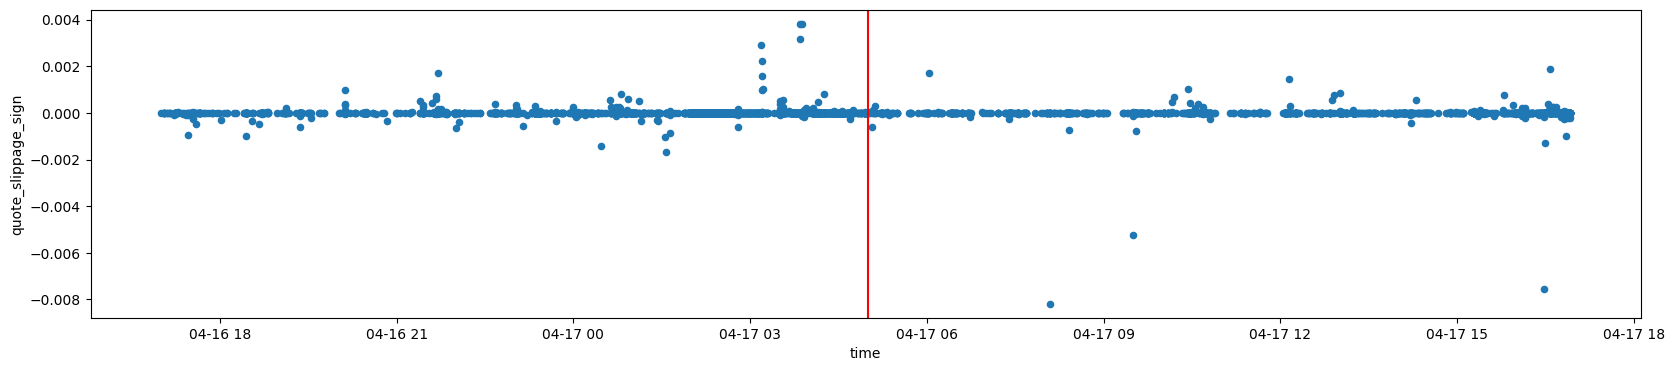

In [19]:
df_trades_1d.plot.scatter(
    x="time", y="quote_slippage_sign", figsize=(20, 4)
)

plt.axvline(x=pump.time.floor("1h") - timedelta(hours=12), color="red")
plt.show()

In [20]:
df_slippages: pd.DataFrame = df_trades_1d.copy()

df_slippages = df_slippages.resample(on="time", rule="1h").agg(
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_abs=("quote_abs", "sum")
).reset_index()

df_slippages = df_slippages[
    df_slippages["time"] >= pump.time.floor("1h") - timedelta(hours=12)
].copy()

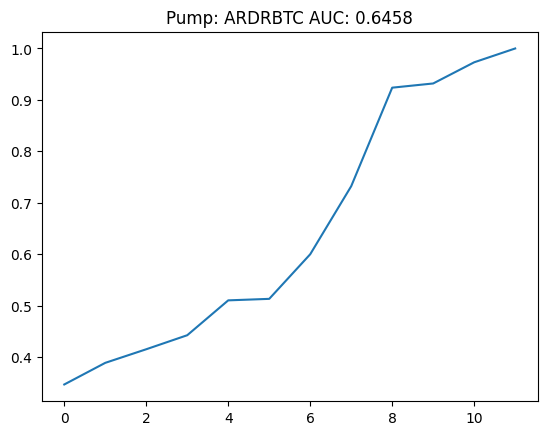

In [21]:
# reverse scale to make hours closer to the pump to have more impact on the metric
df_slippages = df_slippages.iloc[::-1].reset_index(drop=True)

df_slippages["cumsum_ratio"] = df_slippages["quote_slippage_abs"].cumsum() / df_slippages["quote_slippage_abs"].sum()
auc_score: float = auc(
    x=np.linspace(0, 1, 12), y=df_slippages["cumsum_ratio"]
)

plt.plot(df_slippages["cumsum_ratio"])
plt.title(f"Pump: {pump.ticker} AUC: {round(auc_score, 4)}")
plt.show()

<h4>Quote slippage AUC 12hr (relative to overall trading volume)</h4>

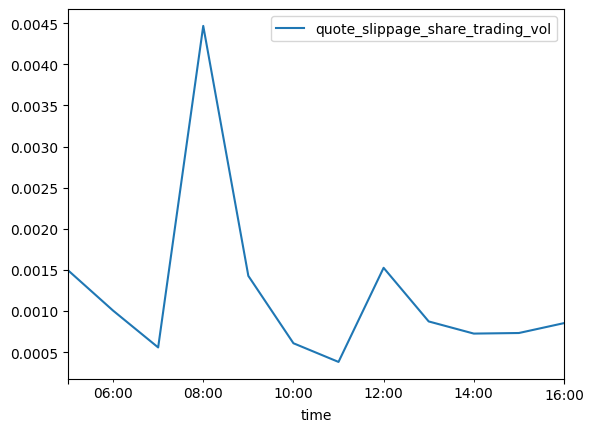

In [22]:
df_slippages["quote_slippage_share_trading_vol"] = df_slippages["quote_slippage_abs"] / df_slippages["quote_abs"]
df_slippages.plot(x="time", y="quote_slippage_share_trading_vol")
plt.show()